In [1]:
# !pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
  
#   print(
#       'User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn]))
#   )
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [3]:
# !kaggle competitions download "titanic"

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 51.7MB/s]


In [4]:
# !unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

SEED = 42

Feature Analysis

In [6]:
print(train_df.info())
train_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
636,637,0,3,"Leinonen, Mr. Antti Gustaf",male,32.0,0,0,STON/O 2. 3101292,7.9250,NaN,S
832,833,0,3,"Saad, Mr. Amin",male,NaN,0,0,2671,7.2292,NaN,C
511,512,0,3,"Webber, Mr. James",male,NaN,0,0,SOTON/OQ 3101316,8.0500,NaN,S


In [7]:
print(test_df.info())
test_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
170,1062,3,"Lithman, Mr. Simon",male,NaN,0,0,S.O./P.P. 251,7.5500,NaN,S
268,1160,3,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S
233,1125,3,"Linehan, Mr. Michael",male,NaN,0,0,330971,7.8792,NaN,Q


Feature Engineering

In [11]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

target = 'Survived'

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)


def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

def generate_features(data_df):
    data_df['family_size'] = data_df['SibSp'] + data_df['Parch']
    data_df['name_length'] = data_df['Name'].apply(len)
    data_df['is_alone'] = 0
    data_df.loc[data_df['family_size'] == 1, 'is_alone'] = 1

    data_df['cabin'] = data_df['Cabin'].str[:1]

    data_df['title'] = 0
    data_df['title'] = data_df.Name.str.extract('([A-Za-z]+)\.')
    data_df['title'].replace(
        ['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don',
         'Dona'],
        ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mrs'],
        inplace=True
    )

    data_df.loc[(data_df.Age.isnull()) & (data_df.title == 'Mr'), 'Age'] = data_df.Age[data_df.title == 'Mr'].mean()
    data_df.loc[(data_df.Age.isnull()) & (data_df.title == 'Mrs'), 'Age'] = data_df.Age[data_df.title == 'Mrs'].mean()
    data_df.loc[(data_df.Age.isnull()) & (data_df.title == 'Master'), 'Age'] = data_df.Age[
        data_df.title == 'Master'].mean()
    data_df.loc[(data_df.Age.isnull()) & (data_df.title == 'Miss'), 'Age'] = data_df.Age[data_df.title == 'Miss'].mean()
    data_df.loc[(data_df.Age.isnull()) & (data_df.title == 'Other'), 'Age'] = data_df.Age[
        data_df.title == 'Other'].mean()

    data_df.loc[data_df.Ticket.str.isdigit(), 'ticket_class'] = 1
    data_df.loc[~data_df.Ticket.str.isdigit(), 'ticket_class'] = 0
    data_df['ticket_class'] = data_df['ticket_class'].apply(int)

    data_df = data_df.drop(columns=['Name', 'Ticket', 'PassengerId', 'Cabin'])
    return data_df


def get_feature_transformer(X: pd.DataFrame):
    X = X.copy()
    X.drop(target, axis='columns', inplace=True)

    categorical_pipeline = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
        ]
    )
    numeric_pipeline = Pipeline(
        steps=[("impute", SimpleImputer(strategy="mean")),
               ("scale", StandardScaler())]
    )
    full_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_pipeline, numerical_features),
            ("categorical", categorical_pipeline, categorical_features),
        ]
    )

    full_transformer.fit(X)
    return full_transformer


def prepare_features(X: pd.DataFrame, feature_transformer: ColumnTransformer, is_debug=True):
    if is_debug:
        print(feature_transformer.get_feature_names_out())

    X_processed = feature_transformer.transform(X)

    y = X[target]
    y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
        y.values.reshape(-1, 1)
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, stratify=y_processed, random_state=SEED
    )

    return X_train, X_test, y_train, y_test


def generate_and_save_submission(test_df: pd.DataFrame, rez_preds, rez_file_name: str):
    submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
    submission_df['PassengerId'] = test_df['PassengerId']
    submission_df['Survived'] = rez_preds
    submission_df.to_csv(rez_file_name, header=True, index=False)
    submission_df.head(10)


Model Engineering

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Ticket', 'Cabin']  # Embarked - nulls (2)
numerical_features = ['Age', 'Fare']  # Embarked - nulls
drop_features = ['PassengerId', 'Name']
target = 'Survived'

all_df = concat_df(train_df, test_df)
generate_features(all_df)
categorical_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'family_size', 'is_alone', 'cabin', 'title', 'ticket_class']
df_train, df_test = divide_df(all_df)
# df_train, df_test = train_df, test_df

# X_train, X_test, y_train, y_test = prepare_features_1(train_df)
feature_transformer = get_feature_transformer(df_train)
X_train, X_test, y_train, y_test = prepare_features(df_train, feature_transformer, False)

In [15]:
X_test.shape

(223, 50)

In [16]:
Y_train = y_train

# https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling
# Modeling step Test differents algorithms 

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

random_state = SEED
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

In [17]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.838399,0.063096,SVC
1,0.782791,0.047623,DecisionTree
2,0.769403,0.058568,AdaBoost
3,0.805337,0.052328,RandomForest
4,0.794799,0.051362,ExtraTrees
5,0.821913,0.036691,GradientBoosting
6,0.830868,0.050316,MultipleLayerPerceptron
7,0.823338,0.042178,KNeighboors
8,0.833899,0.057834,LogisticRegression
9,0.823451,0.057117,LinearDiscriminantAnalysis


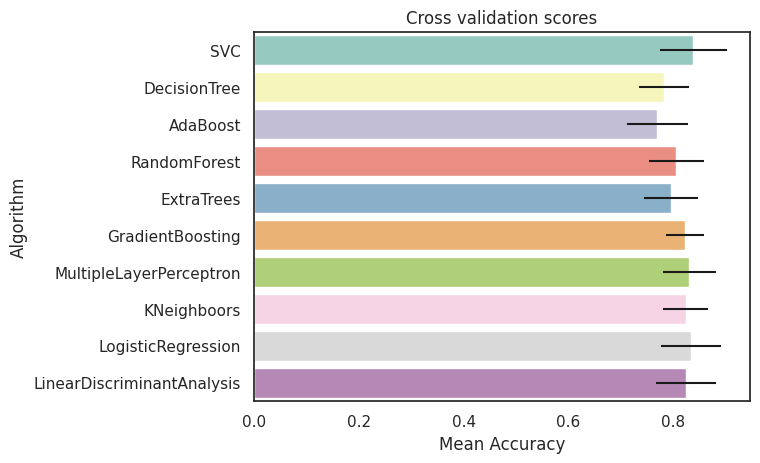

In [18]:
g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

Predictions

In [19]:
n_jobs = 2

In [20]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=SEED)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8158525554047941

In [21]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8338760741745815

In [22]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8323156942559926

In [23]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8263455450022615

In [24]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8383989145183174

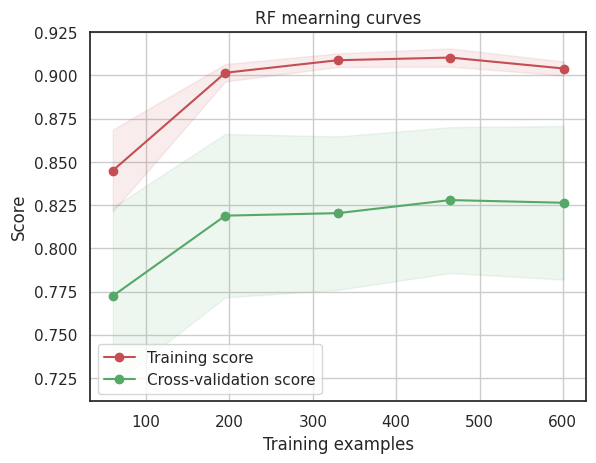

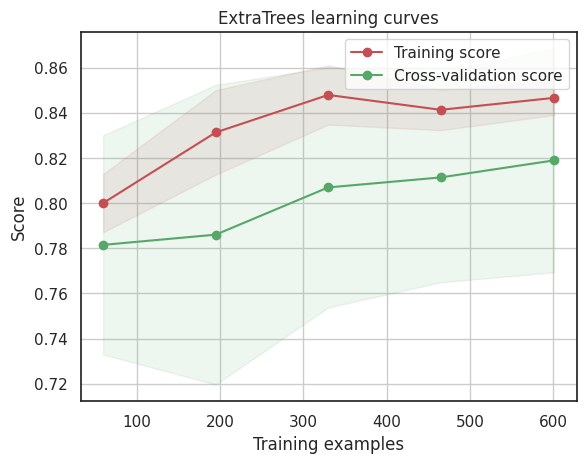

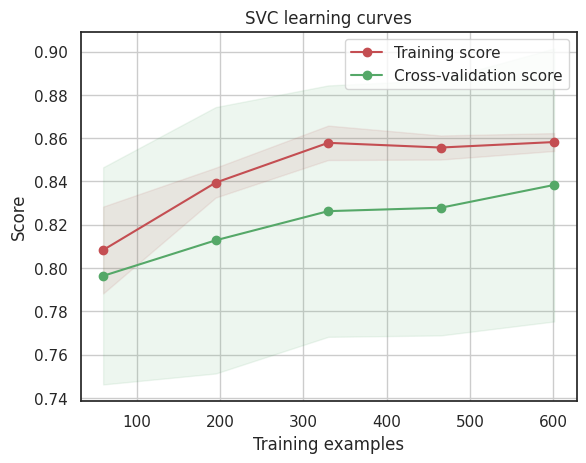

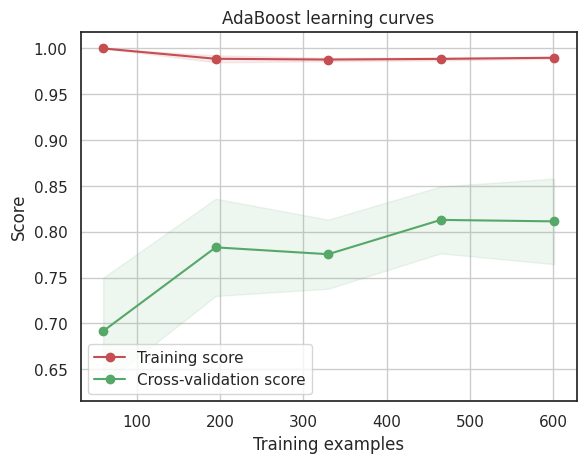

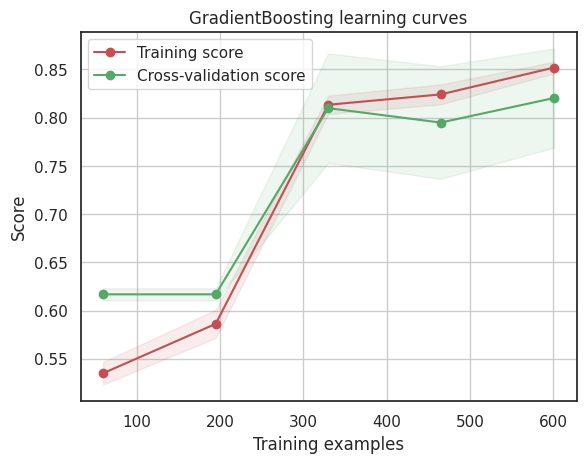

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

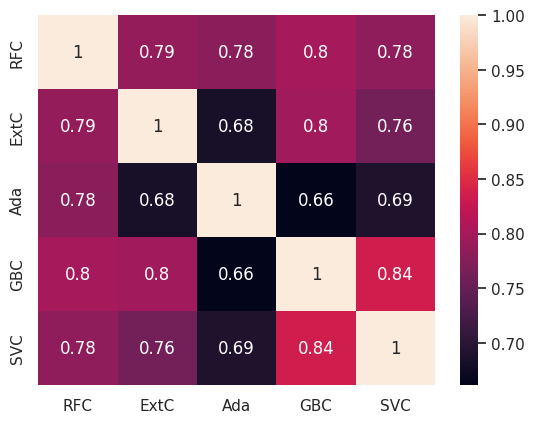

In [26]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [27]:
votingC = VotingClassifier(estimators=[
    ('rfc', RFC_best), 
    ('extc', ExtC_best),
    ('svc', SVMC_best), 
    ('adac',ada_best),
    ('gbc',GBC_best)], voting='soft', n_jobs=n_jobs)

votingC = votingC.fit(X_train, Y_train)

In [28]:
X_rez = feature_transformer.transform(df_test)
rez_preds = votingC.predict(X_rez).astype(int)

generate_and_save_submission(df_test, rez_preds, 'submissions_15.csv')

In [29]:
rez_preds

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,